In [1]:
import torch
import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init

# import scipy

# 추가적인 모듈
import torchvision
# import torchvision.datasets as dset # vision 데이터를 읽어오는 역할
# import torchvision.transforms as transforms # 이미지를 필요에 따라 변환해주는 역할을 하는 모듈
from torch.utils import data # Data의 batch size 설정 및 random하게 섞기 등을 해주는 모듈
import torchsummary

In [2]:
batch_size = 32
learning_rate = 0.0002
num_epoch = 30

transform = torchvision.transforms.Compose(
    torchvision.transforms.ToTensor(),  # convert image to Tensor
)

In [3]:
train_data=torchvision.datasets.MNIST("../DataSets/", train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)
test_data=torchvision.datasets.MNIST("../DataSets/", train=False, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)

dataset_size = len(train_data)
train_size = int(dataset_size * 0.8)
test_size = int(20)
validation_size = dataset_size - train_size - test_size

train_dataset, val_dataset, train_test = data.random_split(train_data, [train_size, validation_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)

In [4]:
print(train_data)
print(train_data[0][0].shape)
print(train_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../DataSets/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([1, 28, 28])


In [5]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # 점선 화살표 부분 맞춰는 코드
        # stride가 1이 아니거나(outplane이 /2로 작아지거나) or in_channel이 out_channel*expansion()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [6]:
class ResCRNN(nn.Module):
    def __init__(self, num_block: int = [3, 3], num_classes: int = 10, init_weights: bool = True) -> None:
        super().__init__()

        self.in_channels = 64
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv2_x = self._make_layer(BottleNeck, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(BottleNeck, 128, num_block[1], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128 * BottleNeck.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplanes, out_channels, stride))
            self.inplanes = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = ResCRNN([3, 3]).to(device)

# 모델이 잘 통과하는지 확인
x = torch.randn(1, 1, 32, 32).to(device)
output = resnet(x)
print(output.size())

# 모델 summary
torchsummary.summary(resnet, (1, 32, 32), device=device.type)

torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             576
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-1

In [105]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResCRNN([3,3]).to(device)

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_array = []
accuracy_array = []

test_model_flag = False

In [106]:
def get_accuracy():
  correct = 0
  total = 0
  with torch.no_grad():
      val_datas = train_test if  test_model_flag is True else test_loader
      for img, label in val_datas:
          x = img.to(device)
          y_ = label.to(device)

          output = model.forward(x)
          _, output_index = torch.max(output, 1)

          total += label.size(0)
          correct += (output_index == y_).sum().float()
      return (correct/total)

In [107]:
train_datas = train_test if test_model_flag is True else train_loader
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_datas):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output= model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if ((j == 0) if test_model_flag is True else (j % 100 == 0)):
            loss_array.append(loss.detach().cpu().numpy())
            aa = get_accuracy()
            print("Accuracy of Test Data: {}, ".format(100*aa), end=" "), print("loss: {}".format(loss_array[-1]))
            accuracy_array.append(aa.detach().cpu().numpy())

epoch 0 is start
Accuracy of Test Data: 9.545272827148438,  loss: 2.3543379306793213
Accuracy of Test Data: 81.31009674072266,  loss: 0.9792035818099976
Accuracy of Test Data: 93.79006958007812,  loss: 0.3668990731239319
Accuracy of Test Data: 95.60296630859375,  loss: 0.09615117311477661
Accuracy of Test Data: 96.56449890136719,  loss: 0.1279456615447998
Accuracy of Test Data: 96.7147445678711,  loss: 0.031309157609939575
Accuracy of Test Data: 97.09535217285156,  loss: 0.05474652722477913
Accuracy of Test Data: 97.23558044433594,  loss: 0.08078088611364365
Accuracy of Test Data: 97.4258804321289,  loss: 0.11123421043157578
Accuracy of Test Data: 97.59615325927734,  loss: 0.09013378620147705
Accuracy of Test Data: 97.68629455566406,  loss: 0.10262656211853027
Accuracy of Test Data: 97.89663696289062,  loss: 0.05466841906309128
Accuracy of Test Data: 97.29566955566406,  loss: 0.09287279844284058
Accuracy of Test Data: 97.93669891357422,  loss: 0.02251037023961544
Accuracy of Test Data:

KeyboardInterrupt: 

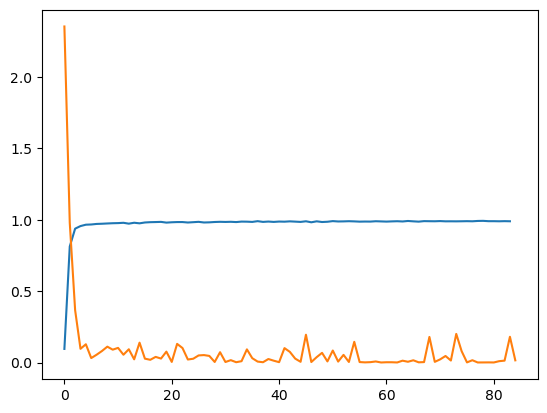

In [108]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(accuracy_array))), accuracy_array[:])
plt.plot(loss_array[:])
plt.show()